# Fraud Detection Models

This notebook aims to create a prediction of fraudulent purchasing in an e-commerce through both supervised and unsupervised machine learning modeling using data composed of devices and IP addresses, along with demographics used in both fraudulent and legitimate purchases.

***

## 1. Data Cleaning

In [1]:
# importing necessary libraries and modules

import numpy as np
import pandas as pd
import itertools

from scipy import special
from datetime import timedelta
from IPython.display import display

In [2]:
# reading necessary data
fraud_df = pd.read_csv('Fraud_Data.csv',header=0)
ISP_df = pd.read_csv('IpAddress_to_Country.csv',header=0)

In [3]:
# checking out the data types for the fraud dataset
fraud_df.dtypes

id                  int64
cadastro           object
compra             object
valor               int64
id_dispositivo     object
fonte              object
browser            object
genero             object
idade               int64
ip                float64
fraude              int64
dtype: object

In [4]:
# checking for null values for the fraud dataset
for col in fraud_df.columns:
    print('Null values in {}: {}'.format(col, fraud_df[col].isnull().sum()))

Null values in id: 0
Null values in cadastro: 0
Null values in compra: 0
Null values in valor: 0
Null values in id_dispositivo: 0
Null values in fonte: 0
Null values in browser: 0
Null values in genero: 0
Null values in idade: 0
Null values in ip: 0
Null values in fraude: 0


In [5]:
# describing the fraud dataset for the fraud dataset
fraud_df.describe()

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [6]:
# checking out the data types for the IP dataset
ISP_df.dtypes

limite_inferior_ip    float64
limite_superior_ip      int64
pais                   object
dtype: object

In [7]:
ISP_df.head()

,limite_inferior_ip,limite_superior_ip,pais
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [8]:
# upper and lower IP limits are in different data types.
# checking whether that was merely a dot by the end.

ip_floats = ISP_df.limite_inferior_ip.apply(lambda x: not x.is_integer()).sum()
print('Non-zero decimals in lower IP limits: {}'.format(ip_floats))

Non-zero decimals in lower IP limits: 0


In [9]:
# turning upper IP limit to a float64 so there'll be no errors in comparing the two datasets
ISP_df.limite_superior_ip = ISP_df.limite_superior_ip.astype(np.float64)
ISP_df.dtypes

limite_inferior_ip    float64
limite_superior_ip    float64
pais                   object
dtype: object

In [10]:
# checking for null values for the IP dataset
for col in ISP_df.columns:
    print('Null values in {}: {}'.format(col, ISP_df[col].isnull().sum()))

Null values in limite_inferior_ip: 0
Null values in limite_superior_ip: 0
Null values in pais: 0


In [11]:
# describing the fraud dataset for the IP dataset
ISP_df.describe()

,limite_inferior_ip,limite_superior_ip
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [12]:
# strange value at 75% percentile for the lower limit,
# checking whether it is merely a display issue

display(ISP_df[ISP_df.limite_inferior_ip == ISP_df.limite_inferior_ip.max()])
display(ISP_df[ISP_df.limite_superior_ip == ISP_df.limite_superior_ip.max()])

,limite_inferior_ip,limite_superior_ip,pais
138845,3.758096e+09,3.758096e+09,Australia


,limite_inferior_ip,limite_superior_ip,pais
138845,3.758096e+09,3.758096e+09,Australia


In [13]:
# defining which country an IP belongs to
def ip_to_country(ip):
    tmp = ISP_df[(ISP_df.limite_inferior_ip <= ip)
            & (ISP_df.limite_superior_ip >= ip)].pais
    if tmp.shape[0] == 1:
        return tmp.iloc[0]

fraud_df["pais"] = fraud_df.ip.apply(ip_to_country)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [14]:
fraud_df.to_csv("fraud_data_country.csv", index=False)

***

## 2. Exploratory Data Analysis

In [15]:
# importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

D:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
# recreating the fraud dataset with country data

fraud_df = pd.read_csv("fraud_data_country.csv", header=0)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Text(0, 0.5, 'Fraud cases')

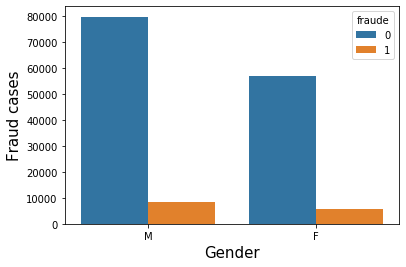

In [17]:
# creating a visualization of number of fraud cases by gender

sns.countplot(x="genero", hue="fraude", data=fraud_df)
plt.xlabel("Gender", fontsize=15)
plt.ylabel("Fraud cases", fontsize=15)

D:\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.42499999999999716, 0.5, 'Purchase value')

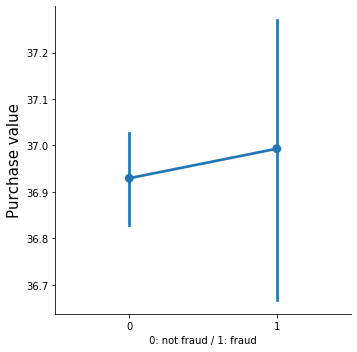

In [18]:
# plotting fraud cases by value
sns.factorplot(x="fraude", y="valor", data=fraud_df)
plt.xlabel(" 0: not fraud / 1: fraud ")
plt.ylabel("Purchase value", fontsize=15)

Text(-5.825000000000003, 0.5, "User's age")

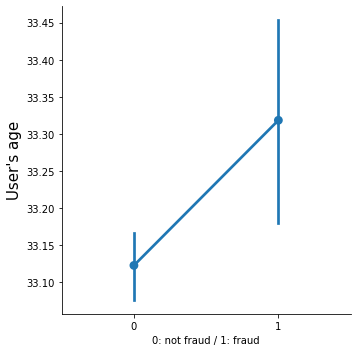

In [19]:
# reproducing the plot for user age

sns.factorplot(x="fraude",y="idade",data=fraud_df)
plt.xlabel("0: not fraud / 1: fraud")
plt.ylabel("User's age", fontsize=15)

Text(0, 0.5, 'Fraudulent cases')

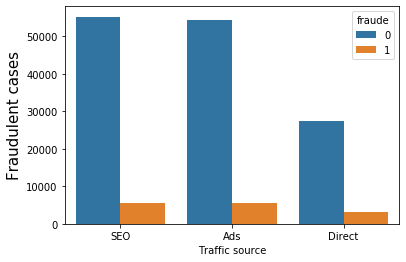

In [20]:
# plotting fraud by traffic source

sns.countplot(x="fonte",hue="fraude",data=fraud_df)
plt.xlabel("Traffic source")
plt.ylabel("Fraudulent cases", fontsize=15)

In [21]:
# grouping fraudulent purchases by country

fraud_sum = fraud_df[fraud_df['fraude'] == 1]["fraude"].groupby(fraud_df.pais).sum()
fraud_sum = fraud_sum.to_frame().reset_index()

not_fraud_sum = fraud_df[fraud_df["fraude"] == 0]["fraude"].groupby(fraud_df.pais).sum()
not_fraud_sum = not_fraud_sum.to_frame().reset_index()

Text(0, 0.5, 'Countries')

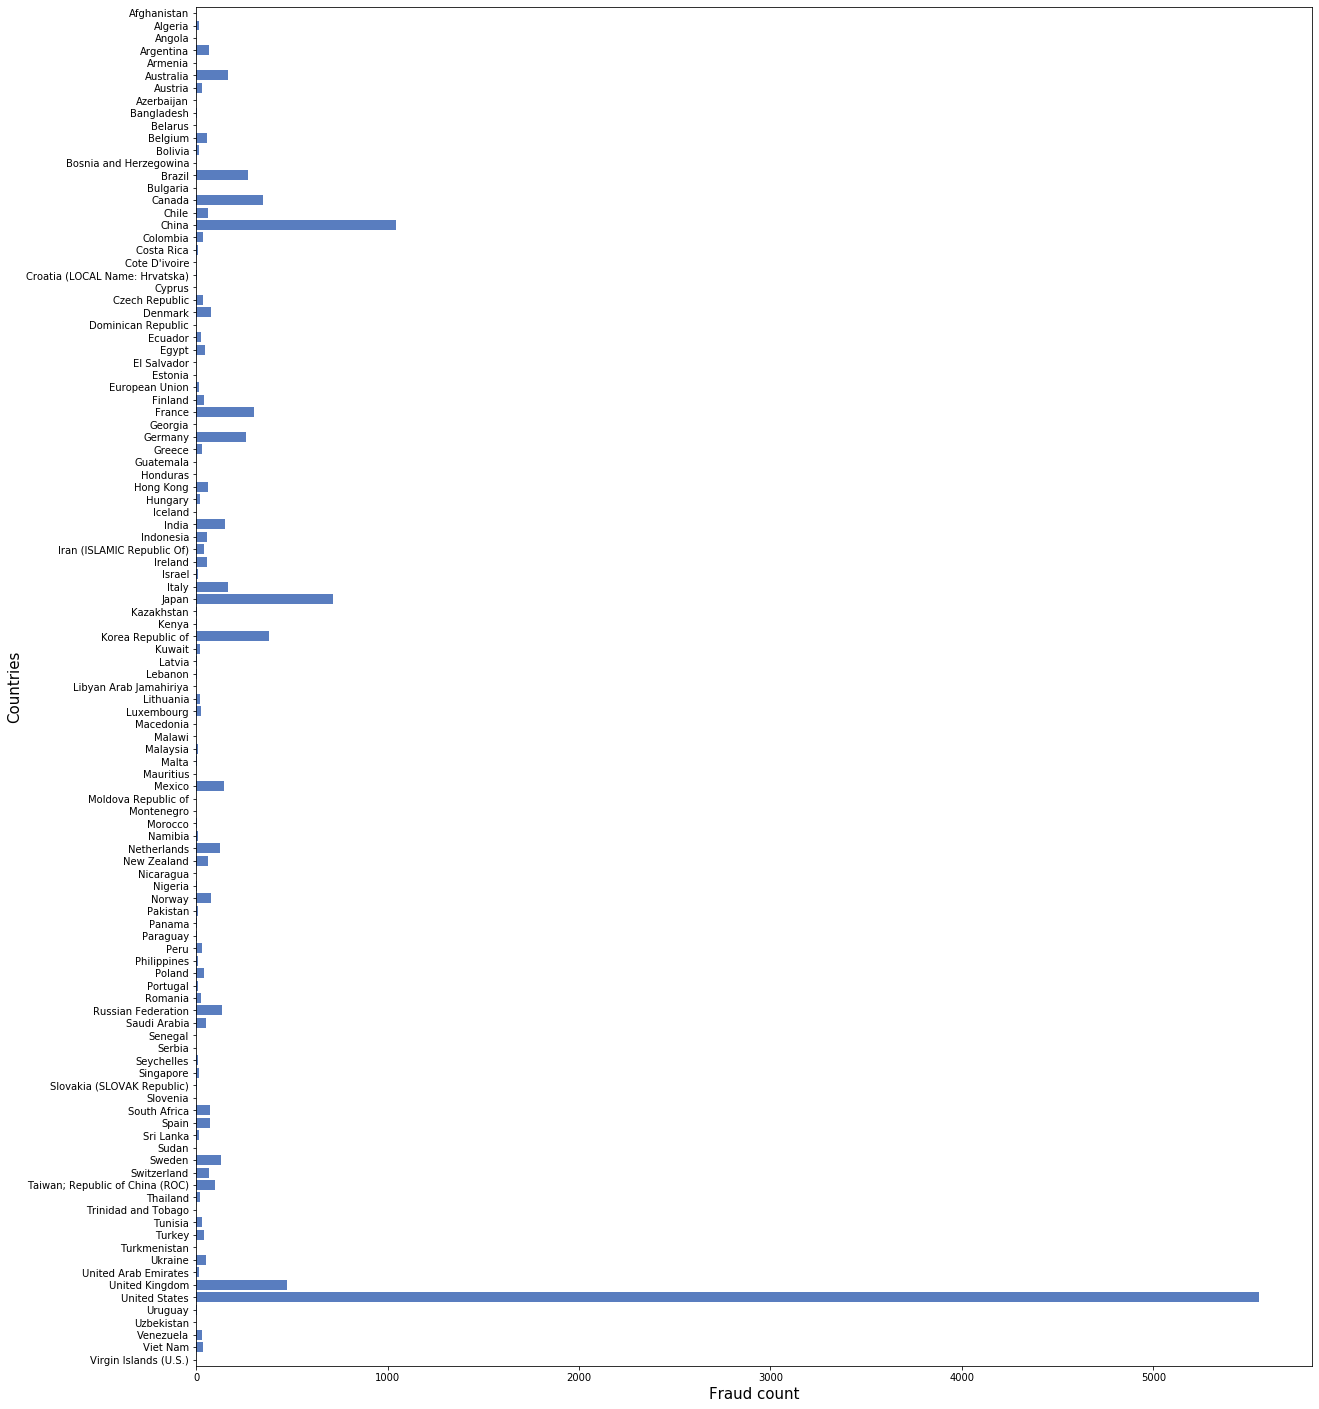

In [22]:
# plotting the fraud results

f, ax = plt.subplots(figsize=(20,25))
sns.set_color_codes("muted")
sns.barplot(x="fraude", y="pais", data=fraud_sum, label="Total", color="b")
plt.xlabel("Fraud count", fontsize=15)
plt.ylabel("Countries", fontsize=15)

In [23]:
# grouping data in a new dataframe

temp_df = pd.DataFrame(columns=("fraud","id_by_device","id_by_ip"))
temp_df["fraude"] = fraud_df["fraude"]

userid_device = fraud_df.groupby("id_dispositivo").id.count()
temp_df["id_by_device"] = fraud_df.id_dispositivo.apply(lambda x: userid_device[x])

userid_ip = fraud_df.groupby("ip").id.count()
temp_df["id_by_ip"] = fraud_df.ip.apply(lambda x: userid_ip[x])